In [36]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [37]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './TCIA_new_splitted'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
torch.cuda.is_available()

False

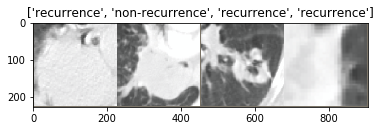

In [39]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [40]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss=[]
    val_loss=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
            #print(phase,train_loss,val_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.plot(train_loss,'r',val_loss,'b')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [41]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [42]:
model_ft = models.alexnet(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
print(num_ftrs)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

4096


Epoch 0/24
----------
train Loss: 0.7692 Acc: 0.4462
val Loss: 0.6205 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.6462 Acc: 0.6462
val Loss: 0.6334 Acc: 0.6667

Epoch 2/24
----------
train Loss: 0.6577 Acc: 0.6769
val Loss: 0.6435 Acc: 0.6667

Epoch 3/24
----------
train Loss: 0.6518 Acc: 0.6154
val Loss: 0.6454 Acc: 0.6667

Epoch 4/24
----------
train Loss: 0.6345 Acc: 0.6769
val Loss: 0.6532 Acc: 0.6667

Epoch 5/24
----------
train Loss: 0.6343 Acc: 0.6769
val Loss: 0.6594 Acc: 0.6667

Epoch 6/24
----------
train Loss: 0.6330 Acc: 0.6769
val Loss: 0.6599 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.6374 Acc: 0.6923
val Loss: 0.6614 Acc: 0.6667

Epoch 8/24
----------
train Loss: 0.6059 Acc: 0.6615
val Loss: 0.6625 Acc: 0.6667

Epoch 9/24
----------
train Loss: 0.6312 Acc: 0.6923
val Loss: 0.6636 Acc: 0.6667

Epoch 10/24
----------
train Loss: 0.6600 Acc: 0.6769
val Loss: 0.6639 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.5814 Acc: 0.7077
val Loss: 0.6641 Acc: 0.6667

Ep

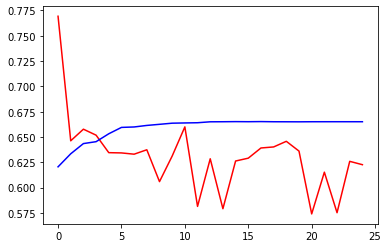

In [43]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

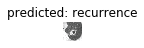

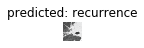

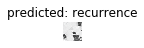

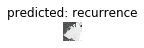

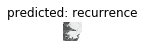

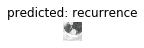

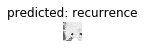

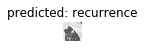

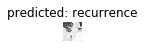

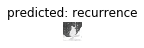

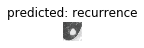

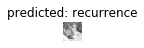

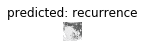

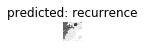

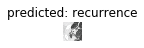

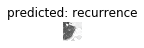

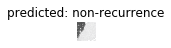

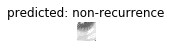

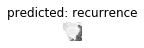

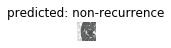

In [61]:
visualize_model(model_ft,num_images=20)

In [67]:
test_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './TCIA_new_splitted'
test_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          test_transforms[x])
                  for x in ['test']}
testloader = {x: torch.utils.data.DataLoader(test_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
testset_sizes = {x: len(test_datasets[x]) for x in ['test']}
class_names = test_datasets['test'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
def visualize_model2(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

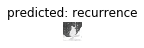

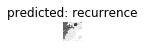

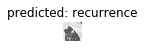

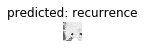

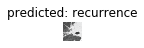

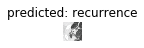

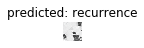

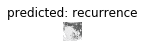

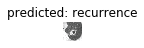

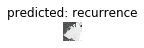

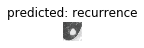

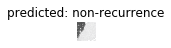

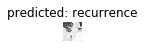

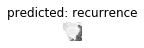

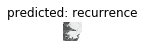

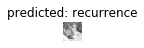

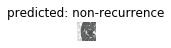

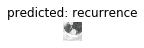

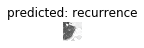

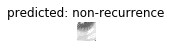

In [64]:
visualize_model2(model_ft,num_images=20)

In [75]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.000005, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.7123 Acc: 0.5538
val Loss: 0.8483 Acc: 0.2667

Epoch 1/24
----------
train Loss: 0.6327 Acc: 0.6154
val Loss: 0.7875 Acc: 0.5333

Epoch 2/24
----------
train Loss: 0.6831 Acc: 0.6000
val Loss: 0.7720 Acc: 0.5333

Epoch 3/24
----------
train Loss: 0.6650 Acc: 0.6615
val Loss: 0.7652 Acc: 0.6000

Epoch 4/24
----------
train Loss: 0.6434 Acc: 0.6769
val Loss: 0.7632 Acc: 0.6667

Epoch 5/24
----------
train Loss: 0.6333 Acc: 0.6923
val Loss: 0.7638 Acc: 0.6667

Epoch 6/24
----------
train Loss: 0.6535 Acc: 0.7077
val Loss: 0.7634 Acc: 0.6667

Epoch 7/24
----------
train Loss: 0.6239 Acc: 0.7077
val Loss: 0.7635 Acc: 0.6667

Epoch 8/24
----------
train Loss: 0.6118 Acc: 0.6769
val Loss: 0.7636 Acc: 0.6667

Epoch 9/24
----------
train Loss: 0.6324 Acc: 0.6615
val Loss: 0.7631 Acc: 0.6667

Epoch 10/24
----------
train Loss: 0.6303 Acc: 0.6615
val Loss: 0.7625 Acc: 0.6667

Epoch 11/24
----------
train Loss: 0.6241 Acc: 0.7077
val Loss: 0.7619 Acc: 0.6667

Ep

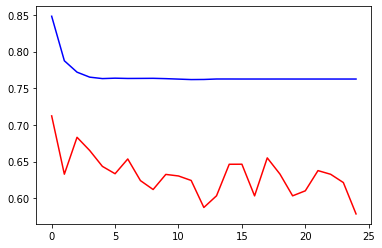

In [76]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [60]:
count=0
for par in model_conv.parameters():
    #print(par)
    count+=1
print(count)

16


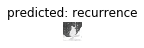

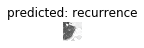

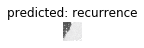

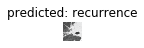

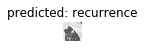

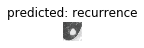

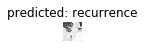

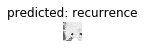

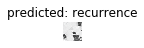

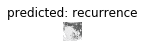

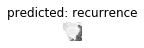

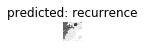

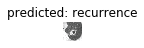

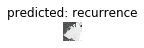

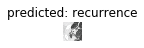

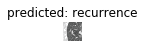

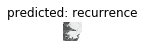

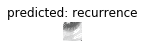

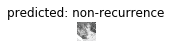

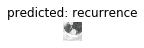

In [77]:
visualize_model2(model_conv,num_images=20)

In [ ]:
model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.000005, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)